In [1]:
import os.path
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import dask
import easygems
import easygems.healpix as egh
from scipy.interpolate import griddata
import matplotlib.colors as mcolors


In [2]:
data_dir = '~/lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5'
t2m_wind_10m_path = os.path.join(data_dir, 'ERA5_monthly.1940-2025.t2m_wind10.nc')
precip_radflx_path = os.path.join(data_dir, 'ERA5_monthly.1940-2025.precip_radflx.nc')

In [3]:
t2m_wind_10m = xr.open_dataset(t2m_wind_10m_path)
t2m = t2m_wind_10m['t2m']
u10 = t2m_wind_10m['u10']
v10 = t2m_wind_10m['v10']
t2m_wind_10m

<xarray.Dataset> Size: 13GB
Dimensions:     (valid_time: 1029, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2025-09-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 16kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 4GB ...
    v10         (valid_time, latitude, longitude) float32 4GB ...
    t2m         (valid_time, latitude, longitude) float32 4GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-27T21:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
precip_radflx = xr.open_dataset(precip_radflx_path)
tp = precip_radflx['tp']
tp

<xarray.DataArray 'tp' (valid_time: 1029, latitude: 721, longitude: 1440)> Size: 4GB
[1068348960 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2025-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 16kB ...
Attributes: (12/32)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgad
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0

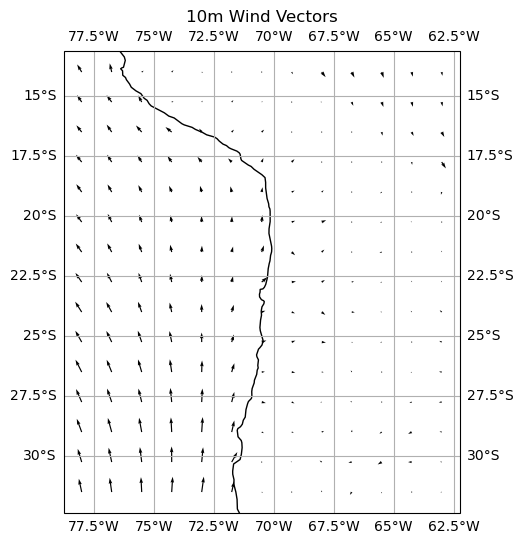

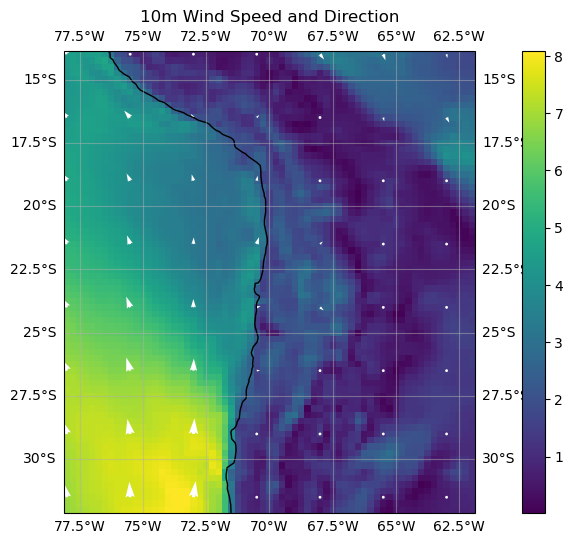

In [5]:
u10 = t2m_wind_10m['u10'].isel(valid_time=0)  # 10m u-component of wind
v10 = t2m_wind_10m['v10'].isel(valid_time=0)  # 10m v-component of wind

lat_min, lat_max = -32, -14  # Longitude range
lon_min, lon_max = 360-78, 360-62   # Latitude range

u10 = u10.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
v10 = v10.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# Method 1: Using quiver plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Subsample the data for better visualization (every 5th point)
skip = 5
u_sub = u10[::skip, ::skip]
v_sub = v10[::skip, ::skip]



# Create quiver plot
quiver = ax.quiver(
    u_sub.longitude, u_sub.latitude,
    u_sub.values, v_sub.values,
    transform=ccrs.PlateCarree(),
    scale=200,  # Adjust this to change arrow length
    width=0.003
)

ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('10m Wind Vectors')
plt.show()

# Method 2: Overlay wind vectors on wind speed
wind_speed = (u10**2 + v10**2)**0.5

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot wind speed as background
wind_speed.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=True)

# Overlay wind vectors
skip = 10
u_sub = u10[::skip, ::skip]
v_sub = v10[::skip, ::skip]

ax.quiver(
    u_sub.longitude, u_sub.latitude,
    u_sub.values, v_sub.values,
    transform=ccrs.PlateCarree(),
    color='white',
    scale=200
)

ax.coastlines()
ax.gridlines(draw_labels=True, alpha=0.5)
plt.title('10m Wind Speed and Direction')
plt.show()

Lons range: -78.0 -62.0
Lats range: -32.0 -14.0
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>


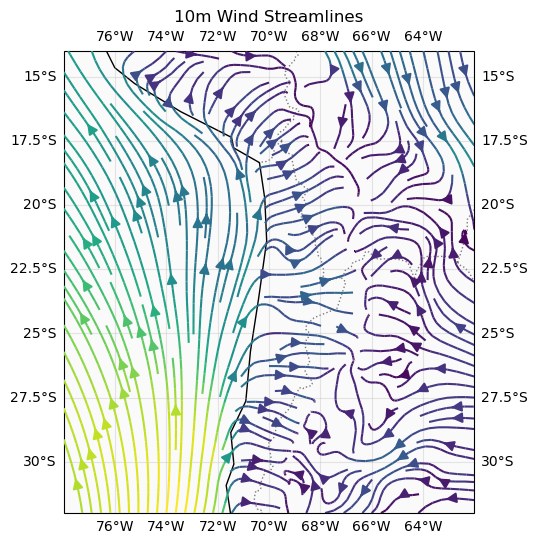

In [ ]:
# Method 2: Using streamplot with coastlines overlay
lons = u10.longitude.values
lats = u10.latitude.values
u_data = u10.values
v_data = v10.values

# Flip latitude if descending
if lats[0] > lats[-1]:
    lats = lats[::-1]
    u_data = np.flip(u_data, axis=0)
    v_data = np.flip(v_data, axis=0)

# Convert longitudes to -180/180 for display
lons_display = np.where(lons > 180, lons - 360, lons)
print("Lons range:", lons_display.min(), lons_display.max())
print("Lats range:", lats.min(), lats.max())

# Create figure with cartopy projection
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines FIRST
ax.coastlines(resolution='110m')
ax.add_feature(cf.BORDERS, linestyle=':', alpha=0.5)
ax.add_feature(cf.LAND, facecolor='lightgray', alpha=0.3)

# Set the extent
ax.set_extent([lons_display.min(), lons_display.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())

# Now add streamplot WITHOUT transform parameter
magnitude = np.sqrt(u_data**2 + v_data**2)
streamplot = ax.streamplot(
    lons_display, lats,
    u_data, v_data,
    density=1.5,
    color=magnitude,  # or 'blue'
    linewidth=1.5,
    arrowsize=1.5,
    cmap='viridis',  # optional
    zorder=3
)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.gridlines(draw_labels=True, alpha=0.3)
plt.title('10m Wind Streamlines')
plt.show()